# Detect Pneumonia Using X-Ray Images

we'll take on the role of a Deep Learning Engineer for an R&D company that focuses on developing cutting edge technologies to assist hospitals in diagnosing patients, particularly children. Thanks to researchers from the University of California, San Diego, the company has access to a dataset containing 5856 chest X-ray images from children, split between a training dataset and a test dataset. Each image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it.

We're tasked with building a deep learning model trained on these images that can accurately classify whether an X-ray indicates signs of pneumonia.

In this project we will build two deep learning models and train them on a dataset containing images of chest X-rays. The aim of this project is to train classifiers on the dataset that can accurately predict whether an X-ray indicates any signs of pneumonia or not.

The models could then be used for developing tools that could aid hospitals in accurately identifying whether a patient has a particular disease or not.

## Importing Libraries

In [ ]:
import tarfile
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt

## Downloading the Dataset

In [ ]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2024-01-31 16:07:00--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.216.245.236, 3.5.25.245, 52.217.123.145, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.216.245.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  39.4MB/s    in 31s     

2024-01-31 16:07:31 (37.8 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



## Uncompressing and Extracting the Data


A helper function can be utilized to uncompress the data. The following is the directory structure of dataset when uncompressed:

chest_xray
- test
  - NORMAL
  - PNEUMONIA
- train
  - NORMAL
  - PNEUMONIA

In [ ]:
def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', 'Output')

In [ ]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='Output/chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset='training',
    seed=417
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='Output/chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='Output/chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size)
)

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


## Data Exploration

In [ ]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
train_set_elem = train_set.take(1)

for images, labels in train_set_elem:
  images = images.numpy()
  labels = labels.numpy()

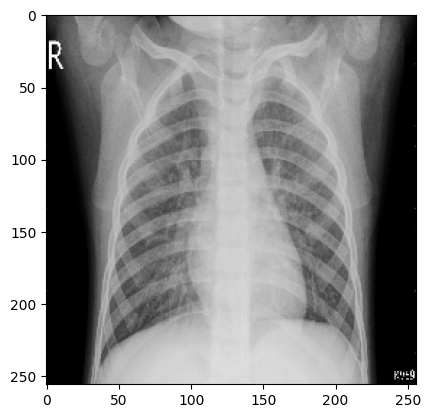

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [ ]:
# setting index val
idx = 0

# ensuring image pixels are in range of [0,1]
plt.imshow(images[idx]/255.0)

# showing image
plt.show()

# printing element label and shape of image
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

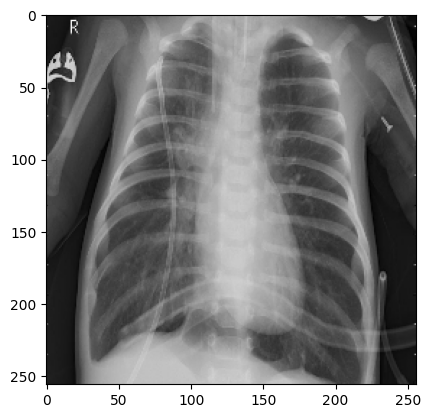

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [ ]:
# taking single element
test_set_elem = test_set.take(1)

for images, labels in test_set_elem:
    images = images.numpy()

# setting index val
idx = 16

# ensuring image pixels are in range of [0,1]
plt.imshow(images[idx]/255.0)

# showing image
plt.show()

# printing element label and shape of image
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

The images do not all exhibit the same level of clarity (dark space vs. light space).

There are some artifacts present in some of the images (e.g., small overview image of lungs in left hand corner, label in bottom right hand corner, etc.) that could prove problematic if our model learns to associate these irrelevant artifacts with the infection.

Seeing as there might be some issues with these artifacts, it wouldn't be a bad idea to augment these images by cropping or flipping/rotating them.

Despite their greyscale appearance, the images actually have 3 channels.

In this project we'll build multiple models, then evaluate those models on the test set at the end. So it's better to have unique variable names for each of those models.

The first model we'll develop will be simple Convolutional Neural Network (CNN).

## Model \#1: Convolutional Neural Network I

In [ ]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
cnn_model.add(layers.MaxPool2D(pool_size=3, strides=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

cnn_model.summary()
cnn_model.fit(train_set_normalized, epochs=5, validation_data=validation_set_normalized)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 63504)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                1016080   
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

The model's ability to correctly screen the x-ray images were actually higher in the validation set than in the training set (76% and 74%, respectively).

This might be reason enough for us to suspect that the model might be overfitted.

We'll improve on this model by tweaking a few of its aspects and adding additional layers until we can get our validation set accuracy above 85% with no more than 10 epochs in our model's training.

## Model \#1: Convolutional Neural Network II

In [ ]:
# instantiating model
cnn_model = models.Sequential()

# zooming and rotating images
cnn_model.add(layers.RandomZoom(height_factor=0.15, width_factor=0.15))
cnn_model.add(layers.RandomRotation(factor=0.2))

cnn_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
cnn_model.add(layers.MaxPool2D(pool_size=3, strides=2))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'))
cnn_model.add(layers.MaxPool2D(pool_size=3, strides=2))
cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(2))

# early stopping callback if val_loss continously increases after 3 periods
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

cnn_model.build((None, img_size, img_size, 3))

cnn_model.summary()

cnn_model.fit(train_set_normalized, epochs=10, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_7 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_7 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_13 (Conv2D)          (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 63, 63, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 31, 31, 64)        73792     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 64)      

## Model \#2: Transfer Learning

In [ ]:
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

base_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

# input layers
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)

# random zoom and rotation of images
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

# fully connected layers
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)
fc1 = layers.Dropout(0.5)(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)
fc2 = layers.Dropout(0.5)(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

# output layer
output = layers.Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])